In [1]:
import numpy as np
import pyvista
import pymeshfix

In [2]:
import openep
from openep._datasets.openep_datasets import DATASET_2

In [4]:
case = openep.load_openep_mat(DATASET_2)
endo = case.create_mesh()

In [5]:
endo_mf = pymeshfix.MeshFix(endo)
endo_mf.repair(joincomp=False, remove_smallest_components=True)
endo = endo_mf.mesh


In [6]:
endo.point_data['Thickness'] = np.full(endo.n_points, fill_value=2, dtype=float)
endo.point_data['Colour'] = np.full(endo.n_points, fill_value=0, dtype=float)
endo.compute_normals(inplace=True)


PolyData (0x26e3baaba00)
  N Cells:	24782
  N Points:	12393
  X Bounds:	-6.555e+01, 4.150e+01
  Y Bounds:	-1.222e+02, -4.681e+01
  Z Bounds:	1.006e+02, 1.655e+02
  N Arrays:	4

In [7]:
epi = endo.copy(deep=True)
epi.points += epi.point_data['Normals'] * epi.point_data['Thickness'][:, np.newaxis]
epi.point_data['Colour'][:] = 1


In [8]:
combined = endo + epi
combined.set_active_scalars('Colour')

In [9]:
def round_up(value, nearest):
    return np.ceil(value / nearest) * nearest
def round_down(value, nearest):
    return np.floor(value / nearest) * nearest


In [10]:
slice_thickness = 10  # mm
low_values = np.asarray(combined.bounds[::2])
high_values = np.asarray(combined.bounds[1::2])

low_values = round_down(low_values, nearest=slice_thickness) - slice_thickness / 2
high_values = round_up(high_values, nearest=slice_thickness) + slice_thickness / 2


In [11]:
low_x, low_y, low_z = low_values
high_x, high_y, high_z = high_values
bounds = np.asarray([low_x, high_x, low_y, high_y, low_z, high_z])

n_slices = (1 + (high_values - low_values) / slice_thickness).astype(int)
centre = (low_values + high_values) / 2


In [12]:
axis = 0

slices = []
normal = np.zeros(3)
normal[axis] = 1
origin = combined.center
for slice_num in range(n_slices[axis]):

    origin[axis] = low_values[axis] + slice_num * slice_thickness
    s = combined.slice(normal=normal, origin=origin, contour=False)
    slices.append(s)


c:\users\paul\documents\software\development\pyvista\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Install ``ipygany`` to use this feature.

Falling back to a static output.
  warnings.warn(


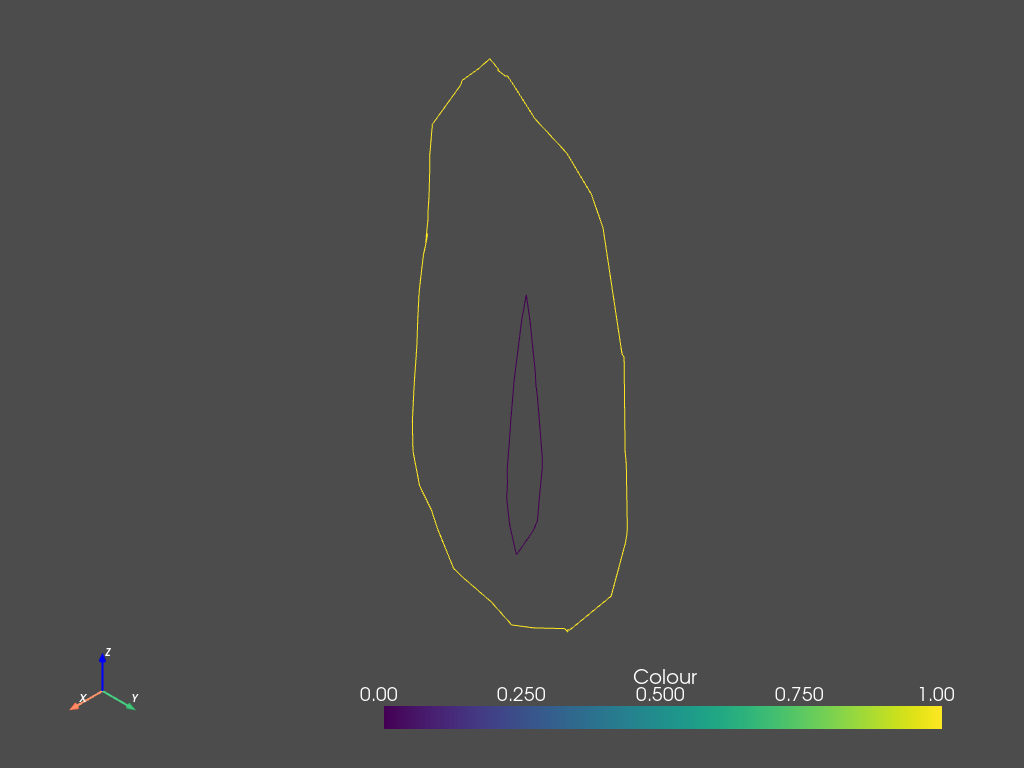

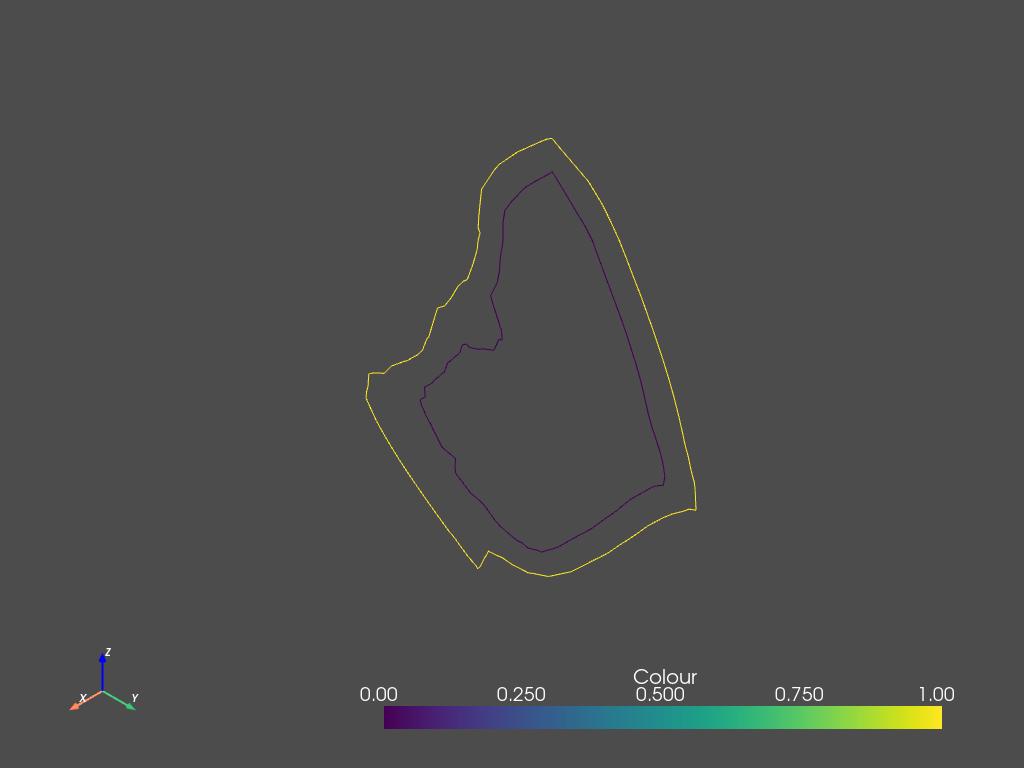

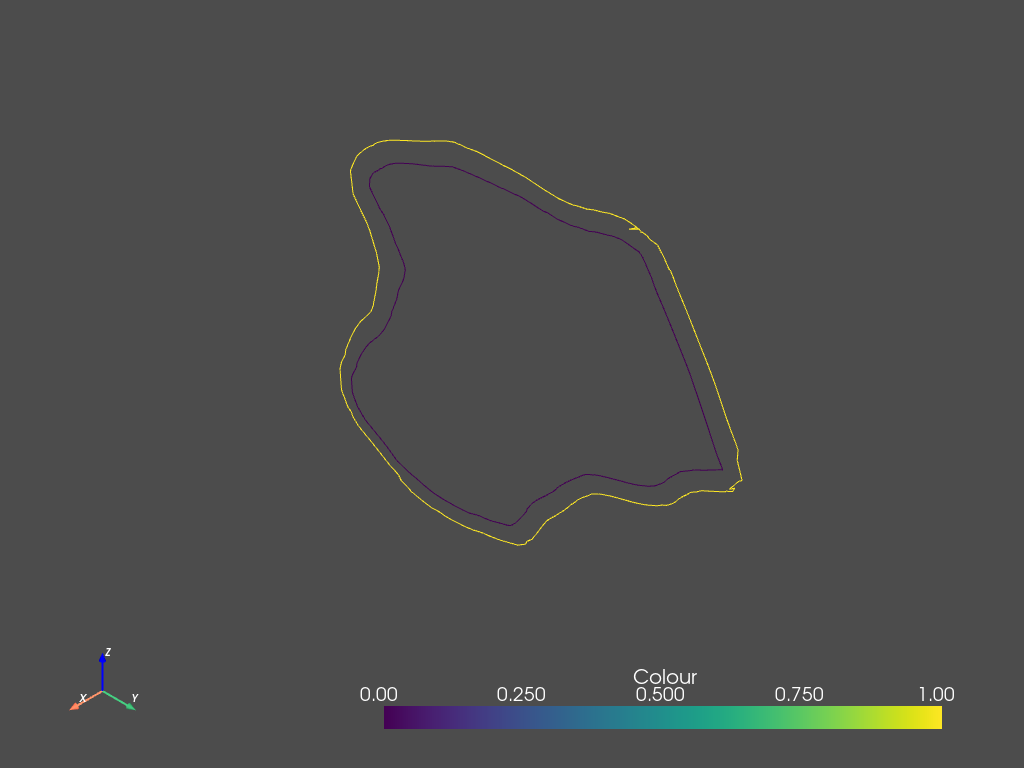

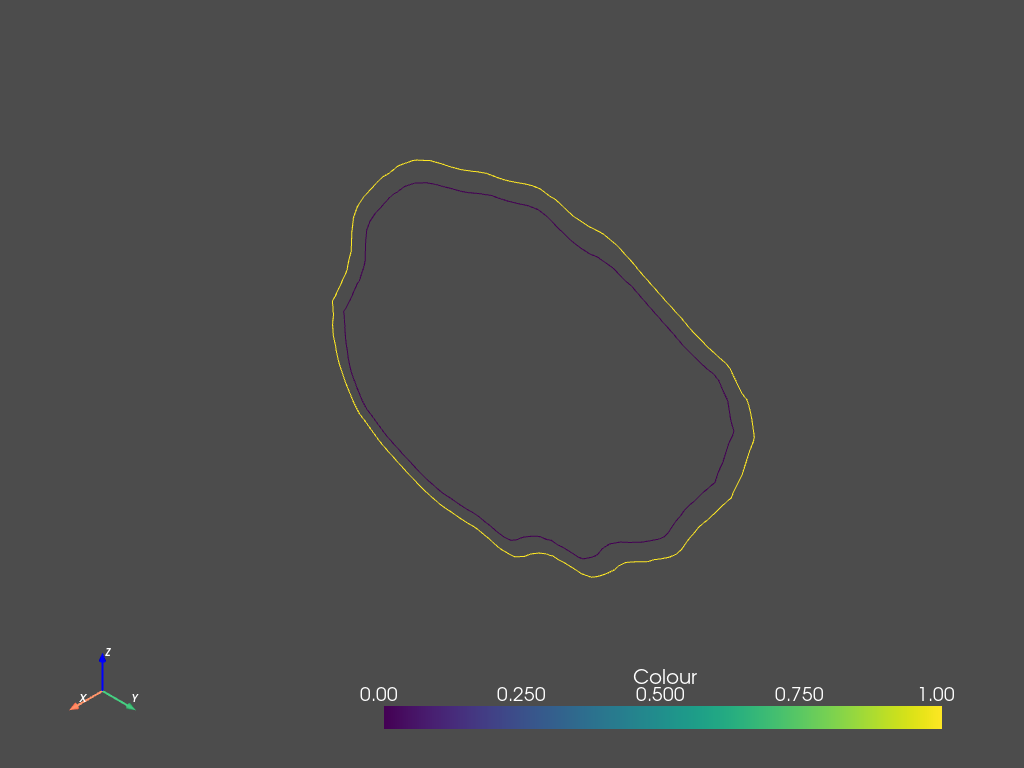

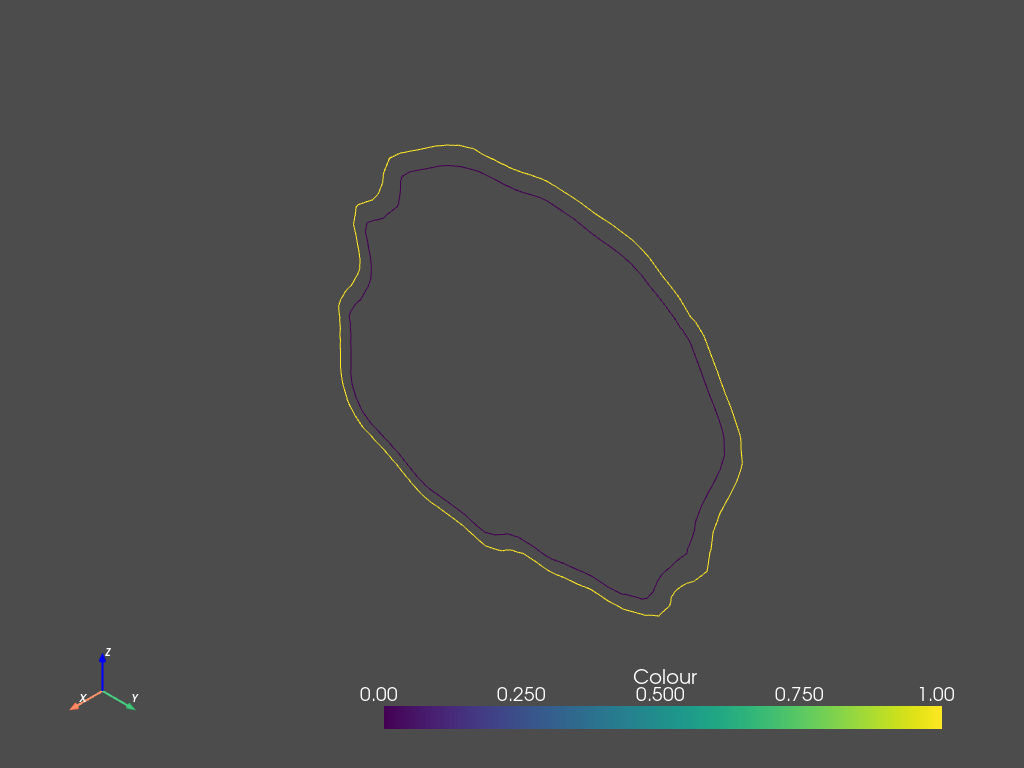

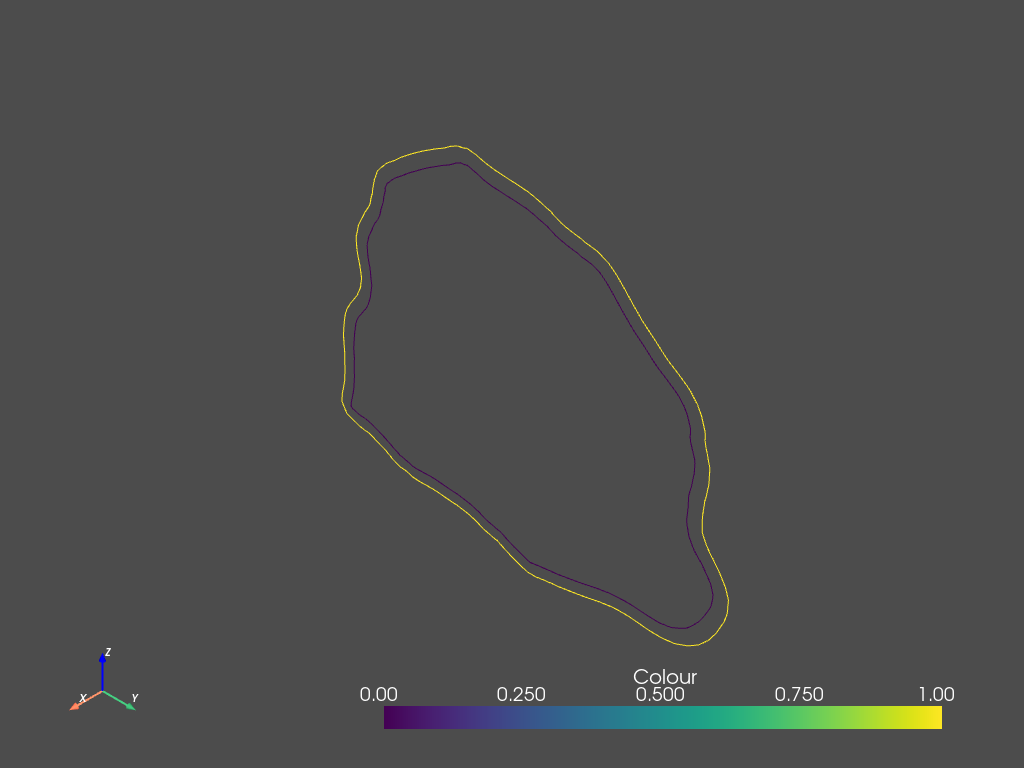

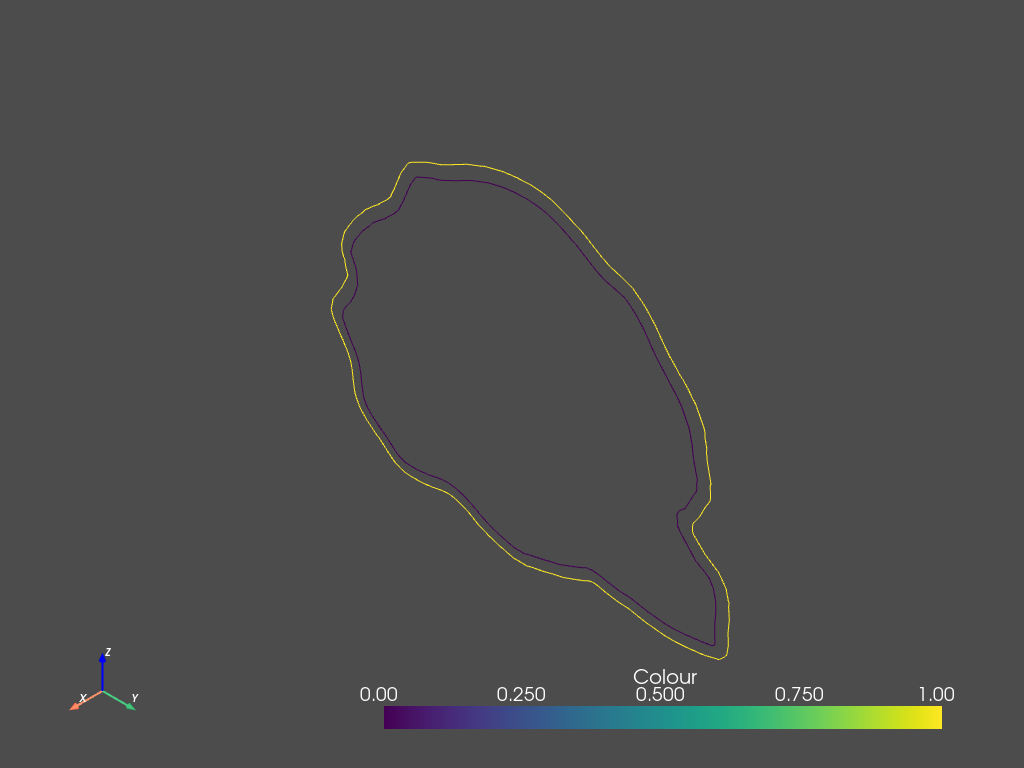

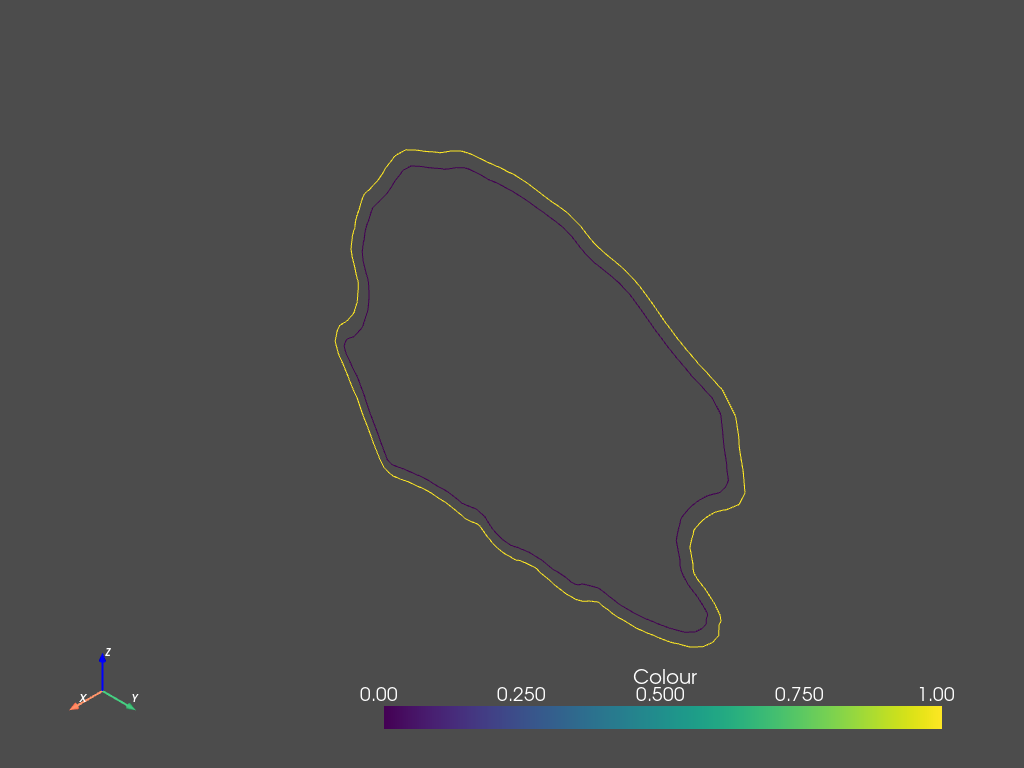

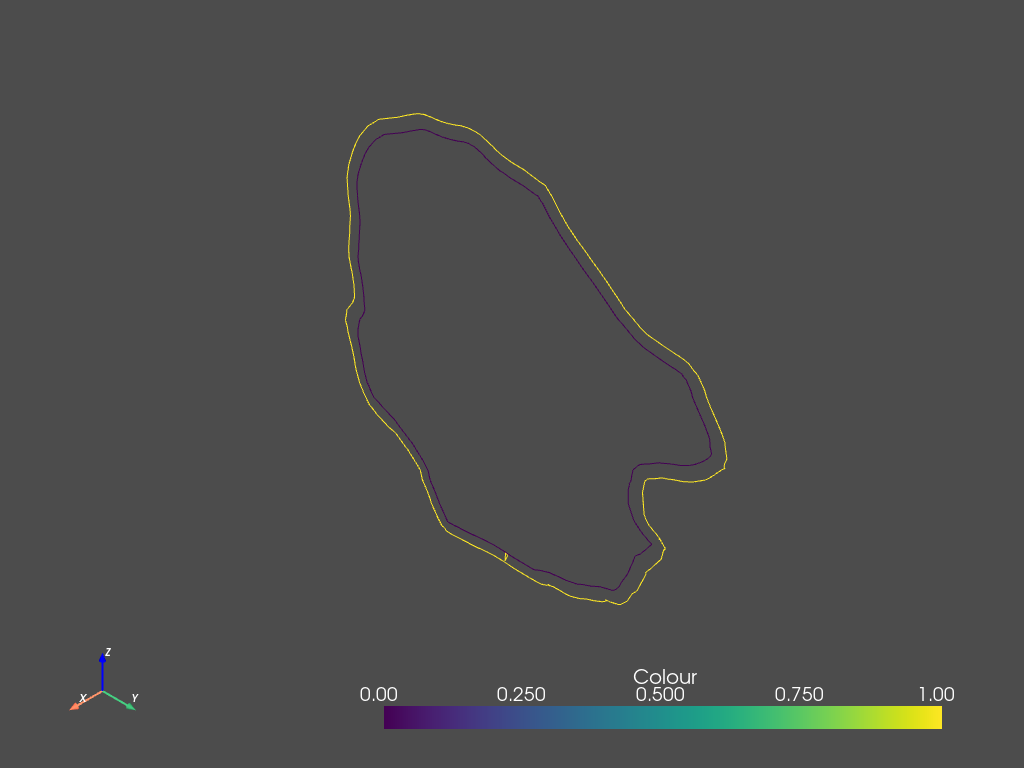

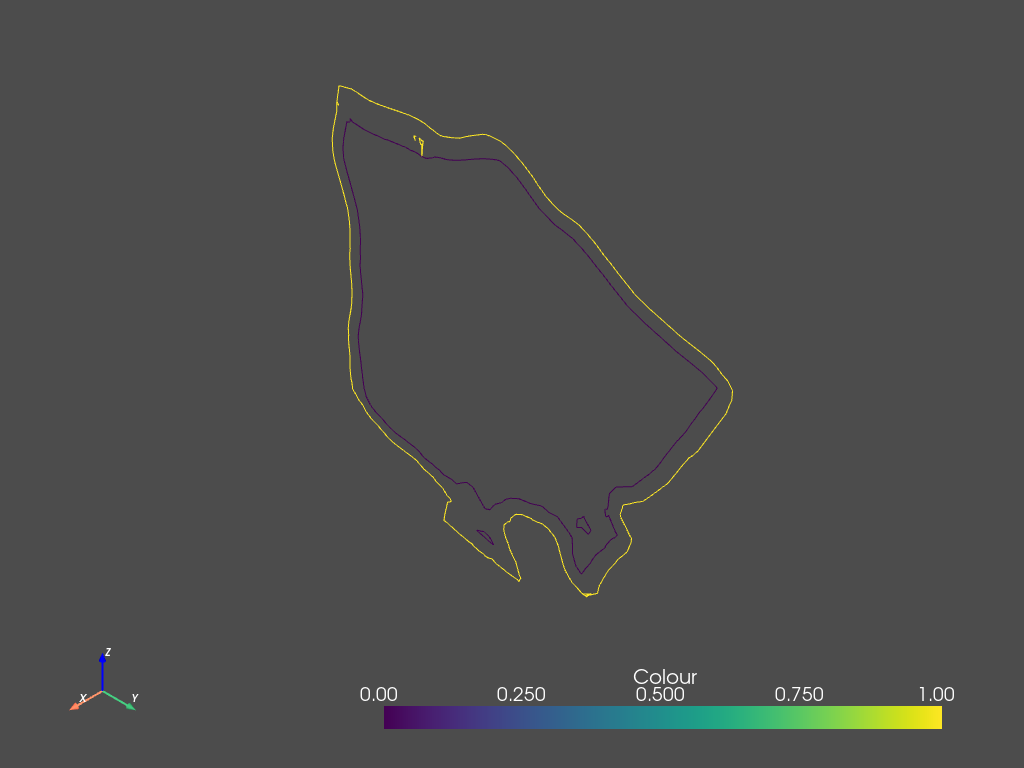

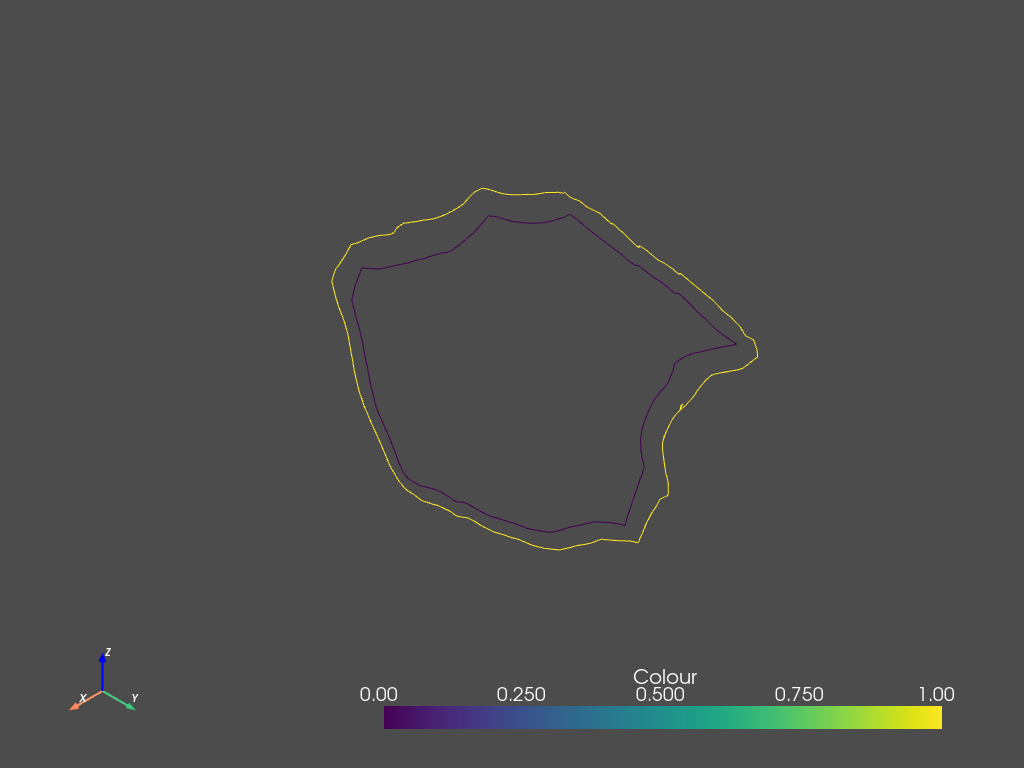

In [15]:
for s in slices:
    try:
        s.plot(jupyter_backend='ipygany')
    except:
        pass


In [16]:
def voxelize(mesh, density=None, bounds=None, check_surface=True, inside_out=False):

    """Voxelize mesh to UnstructuredGrid.

    Parameters
    ----------
    density : float or list
        The uniform size of the voxels when single float passed.
        A list of densities along x,y,z directions.
        Defaults to 1/100th of the mesh length.
    bounds : sequence, optional
            A 6-length sequence overriding the bounds of the mesh.
    check_surface : bool
        Specify whether to check the surface for closure. If on, then the
        algorithm first checks to see if the surface is closed and
        manifold. If the surface is not closed and manifold, a runtime
        error is raised.
    inside_out : bool, optional
            By default, points inside the surface are marked inside or sent
            to the output. If ``inside_out`` is ``True``, then the points
            outside the surface are marked inside.
    """

    if density is None:
        density = mesh.length / 100
    if isinstance(density, (int, float)):
        density_x, density_y, density_z = [density] * 3
    if isinstance(density, (list, set, tuple)):
        density_x, density_y, density_z = density
    
    if bounds is None:
        bounds = mesh.bounds

    x_min, x_max, y_min, y_max, z_min, z_max = bounds

    x = np.arange(x_min, x_max, density_x)
    y = np.arange(y_min, y_max, density_y)
    z = np.arange(z_min, z_max, density_z)
    x, y, z = np.meshgrid(x, y, z)

    # Create unstructured grid from the structured grid
    grid = pyvista.StructuredGrid(x, y, z)
    ugrid = pyvista.UnstructuredGrid(grid)

    # get part of the mesh within the mesh's bounding surface.
    selection = ugrid.select_enclosed_points(
        mesh.extract_surface(), tolerance=0.0, check_surface=check_surface, inside_out=inside_out,
    )
    mask = selection.point_data['SelectedPoints'].view(np.bool_)

    # extract cells from point indices
    vox = ugrid.extract_points(mask)
    return vox


## Voxelise the epi, remove points further than thickness away

In [121]:
def remove_points(self, remove, mode='any', keep_scalars=True, inplace=False, n_points_per_face=3):
    """Rebuild a mesh by removing points.

    Only valid for meshes in which all faces have the same number of points.

    Parameters
    ----------
    remove : np.ndarray
        If remove is a bool array, points that are ``True`` will
        be removed.  Otherwise, it is treated as a list of
        indices.

    mode : str, optional
        When ``'all'``, only faces containing all points flagged
        for removal will be removed.  Default ``'any'``.

    keep_scalars : bool, optional
        When ``True``, point and cell scalars will be passed on to
        the new mesh.

    inplace : bool, optional
        Updates mesh in-place.  Defaults to ``False``.

    Returns
    -------
    pyvista.PolyData
        Mesh without the points flagged for removal.

    numpy.ndarray
        Indices of new points relative to the original mesh.

    Examples
    --------
    Remove the first 100 points from a sphere.

    >>> import pyvista as pv
    >>> sphere = pv.Sphere()
    >>> reduced_sphere, ridx = sphere.remove_points(range(100, 250))
    >>> reduced_sphere.plot(show_edges=True, line_width=3)

    """
    remove = np.asarray(remove)

    # np.asarray will eat anything, so we have to weed out bogus inputs
    if not issubclass(remove.dtype.type, (np.bool_, np.integer)):
        raise TypeError('Remove must be either a mask or an integer array-like')

    if remove.dtype == np.bool_:
        if remove.size != self.n_points:
            raise ValueError('Mask different size than n_points')
        remove_mask = remove
    else:
        remove_mask = np.zeros(self.n_points, np.bool_)
        remove_mask[remove] = True

    assert self.faces.size % (n_points_per_face + 1) == 0

    f = self.faces.reshape(-1, n_points_per_face + 1)[:, 1:]
    vmask = remove_mask.take(f)
    if mode == 'all':
        fmask = ~(vmask).all(1)
    else:
        fmask = ~(vmask).any(1)

    # Regenerate face and point arrays
    uni = np.unique(f.compress(fmask, 0), return_inverse=True)
    new_points = self.points.take(uni[0], 0)

    nfaces = fmask.sum()
    faces = np.empty((nfaces, n_points_per_face + 1), dtype=pyvista.ID_TYPE)
    faces[:, 0] = n_points_per_face
    faces[:, 1:] = np.reshape(uni[1], (nfaces, n_points_per_face))

    newmesh = pyvista.PolyData(new_points, faces, deep=True)
    ridx = uni[0]

    # Add scalars back to mesh if requested
    if keep_scalars:
        for key in self.point_data:
            newmesh.point_data[key] = self.point_data[key][ridx]

        for key in self.cell_data:
            try:
                newmesh.cell_data[key] = self.cell_data[key][fmask]
            except:
                pass
    
    # Return vtk surface and reverse indexing array
    if inplace:
        self.overwrite(newmesh)
        return self, ridx
    return newmesh, ridx


In [ ]:
epi_voxels = voxelize(epi, bounds=bounds, density=[5, 0.2, 0.2], check_surface=True, inside_out=False)


In [100]:
epi_voxels.compute_implicit_distance(epi, inplace=True)


UnstructuredGrid (0x26e40f4c5e0)
  N Cells:	1317159
  N Points:	1437975
  X Bounds:	-7.000e+01, 4.500e+01
  Y Bounds:	-1.232e+02, -4.520e+01
  Z Bounds:	9.900e+01, 1.674e+02
  N Arrays:	3

In [106]:
to_remove = epi_voxels['implicit_distance'] > 2

In [126]:
epi_voxels.faces = epi_voxels.cells
shell, ridx = remove_points(epi_voxels, remove=to_remove, mode='any', keep_scalars=True, inplace=False, n_points_per_face=8)

In [130]:
shell.slice(normal=[1, 0, 0], origin=[5, -84.20000000000289, 133.20000000000067])

PolyData (0x26e90172ac0)
  N Cells:	0
  N Points:	0
  X Bounds:	1.000e+00, -1.000e+00
  Y Bounds:	1.000e+00, -1.000e+00
  Z Bounds:	1.000e+00, -1.000e+00
  N Arrays:	3

In [131]:
shell_slices = shell.slice_along_axis(axis='x', n=13)

In [138]:
shell_slices = pyvista.UnstructuredGrid(shell).slice_along_axis(axis='x', n=13)

c:\users\paul\documents\software\development\pyvista\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


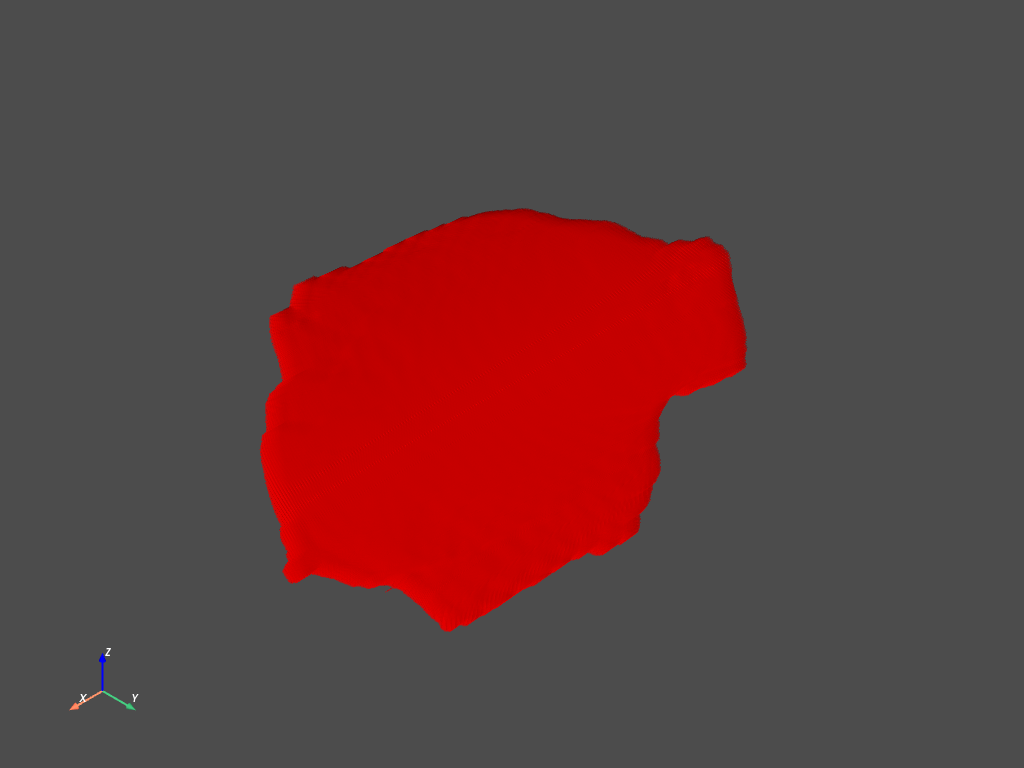

In [141]:
pyvista.UnstructuredGrid(shell).plot(color='red', opacity=0.3)

## Create and endo and epi, take the difference

In [17]:
endo_voxels = voxelize(endo, bounds=bounds, density=[10, 0.1, 0.1], check_surface=True, inside_out=False)


In [18]:
epi_voxels = voxelize(epi, bounds=bounds, density=[10, 0.1, 0.1], check_surface=True, inside_out=True)


c:\users\paul\documents\software\development\pyvista\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


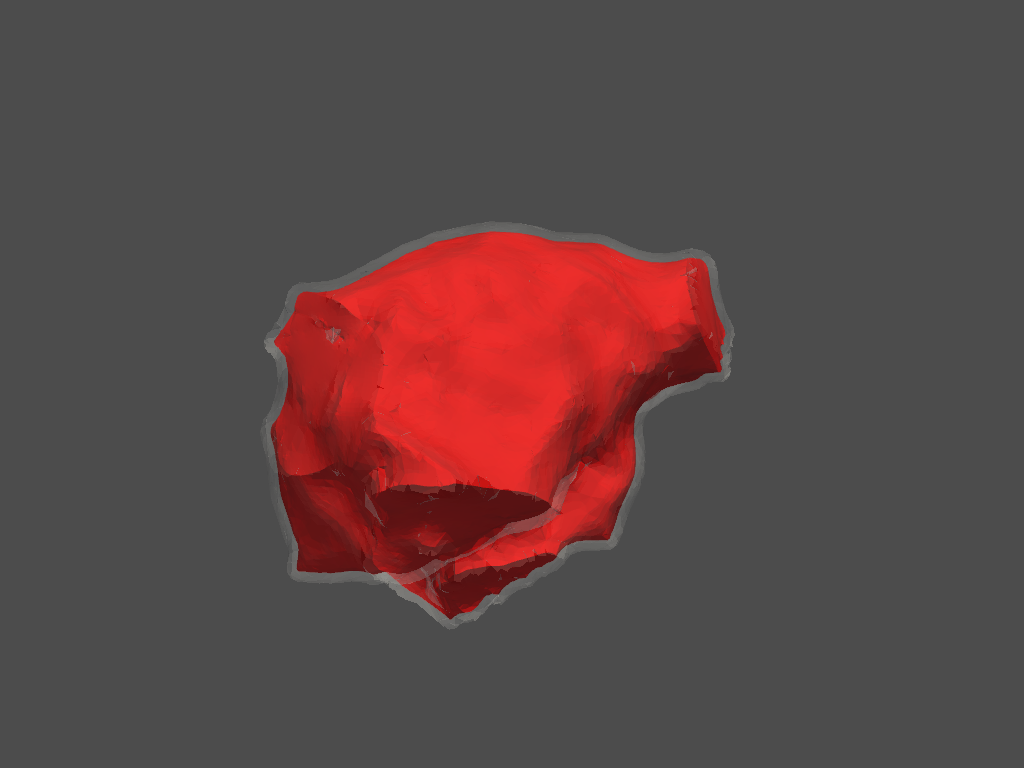

In [21]:
plotter = pyvista.Plotter()
plotter.add_mesh(epi, color='white', opacity=0.2)
plotter.add_mesh(endo, color='red')
plotter.show()

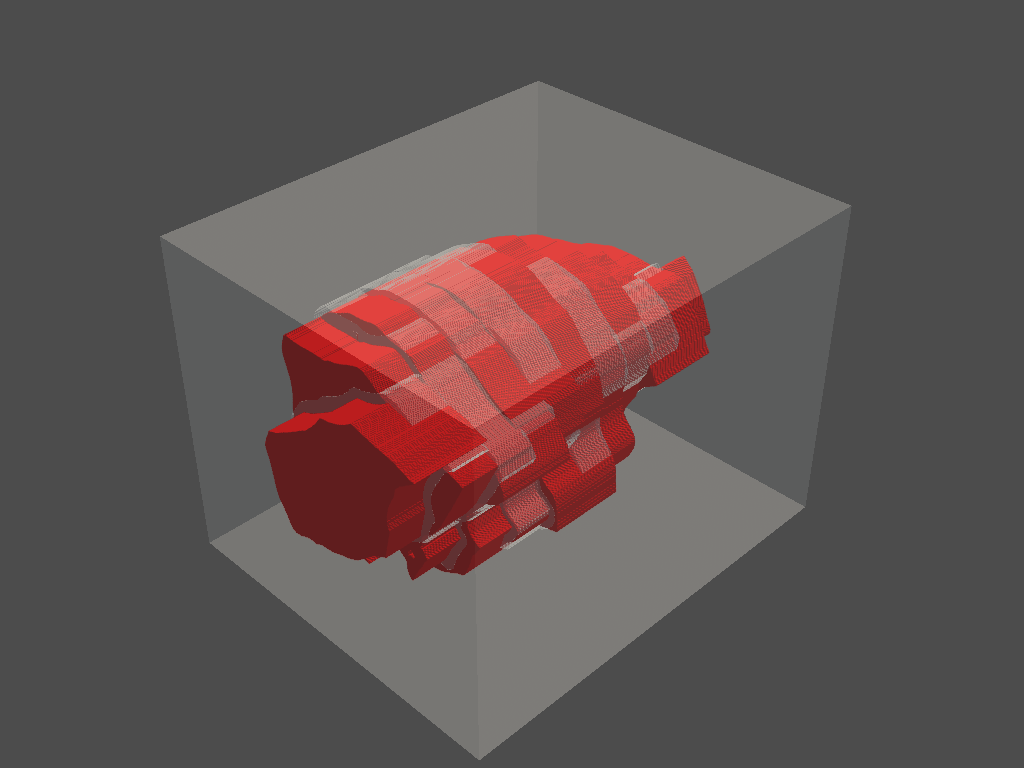

In [22]:
plotter = pyvista.Plotter()
plotter.add_mesh(epi_voxels, color='white', opacity=0.3)
plotter.add_mesh(endo_voxels, color='red')
plotter.show()


In [45]:
endo_voxels.plot()

Scene(background_color='#4c4c4c', camera={'position': [70.87545980431528, 2.275459804312362, 219.2754598043125…

In [46]:
epi_voxels.plot()

Scene(background_color='#4c4c4c', camera={'position': [85.47798596222849, 15.427985962225648, 230.427985962225…

In [47]:
voxels = endo_voxels + epi_voxels
n_slices = np.unique(voxels.points[:, 0]).size
voxel_slices = voxels.slice_along_axis(axis='x', n=n_slices)


In [48]:
n_slices

13

In [49]:
for s in voxel_slices:
    try:
        s.plot()
    except:
        pass
    

# ===========================================
# Using pyvista's slice_along_axis

In [51]:
axis = 0
slices = combined.slice_along_axis(
    n=n_slices[axis]-1,
    axis=axis,
    bounds=bounds,
)


In [52]:
slices

MultiBlock (0x7f9578f3e340)
  N Blocks:	13
  X Bounds:	-63.083, 43.083
  Y Bounds:	-128.693, -47.075
  Z Bounds:	99.302, 167.034

In [55]:
slices[1].points

pyvista_ndarray([[-63.08333333, -74.65703586, 129.63707987],
                 [-63.08333333, -75.24196636, 130.09186544],
                 [-63.08333333, -72.85271498, 123.68514493],
                 [-63.08333333, -72.96192855, 124.52094124],
                 [-63.08333333, -73.23269667, 128.4690227 ],
                 [-63.08333333, -73.25753175, 128.50532187],
                 [-63.08333333, -75.5663903 , 130.3954157 ],
                 [-63.08333333, -72.91636259, 121.09522025],
                 [-63.08333333, -72.75560402, 121.96885095],
                 [-63.08333333, -72.77251348, 122.76362244],
                 [-63.08333333, -73.02947113, 125.94066348],
                 [-63.08333333, -72.93380866, 126.32119403],
                 [-63.08333333, -73.41216316, 128.63192693],
                 [-63.08333333, -73.01034785, 120.81506545],
                 [-63.08333333, -72.79558118, 126.82709755],
                 [-63.08333333, -72.90796044, 127.36877448],
                 [-63.08

# ============================================
# Voxelize first

In [56]:
bounds

array([ -75.,   55., -145.,  -35.,   85.,  175.])

In [88]:
slices[2].plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [39]:
voxels = pyvista.voxelize(
    combined,
    check_surface=False,
    density=[1, 1, 1],
)

In [30]:
voxels.bounds

(-66.74468889713287,
 43.255311102867125,
 -132.03929526042938,
 -46.039295260429384,
 99.15148951435089,
 167.15148951435089)

In [60]:
import pymeshfix

In [74]:
epi_mf = pymeshfix.MeshFix(epi)
epi_mf.repair(joincomp=False, remove_smallest_components=True)
epi_watertight = epi_mf.mesh

endo_mf = pymeshfix.MeshFix(endo)
endo_mf.repair(joincomp=False, remove_smallest_components=True)
endo_watertight = endo_mf.mesh


In [76]:
combined_watertight = endo_watertight + endo_watertight

In [57]:
combined_mf = pymeshfix.MeshFix(combined)
combined_mf.repair(joincomp=True, remove_smallest_components=False)


93
84
95
108
141
67
93
322
84
95
108
141
67


In [59]:
combined_mf.mesh

PolyData,Information
N Cells,25814
N Points,12909
X Bounds,"-6.674e+01, 4.346e+01"
Y Bounds,"-1.242e+02, -4.527e+01"
Z Bounds,"9.915e+01, 1.675e+02"
N Arrays,0


In [78]:
combined_watertight

PolyData,Information
N Cells,49564
N Points,12393
X Bounds,"-6.555e+01, 4.150e+01"
Y Bounds,"-1.222e+02, -4.681e+01"
Z Bounds,"1.006e+02, 1.655e+02"
N Arrays,0


In [60]:
combined_mf.mesh.plot(opacity=0.1)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

c:\users\paul\documents\software\development\pyvista\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


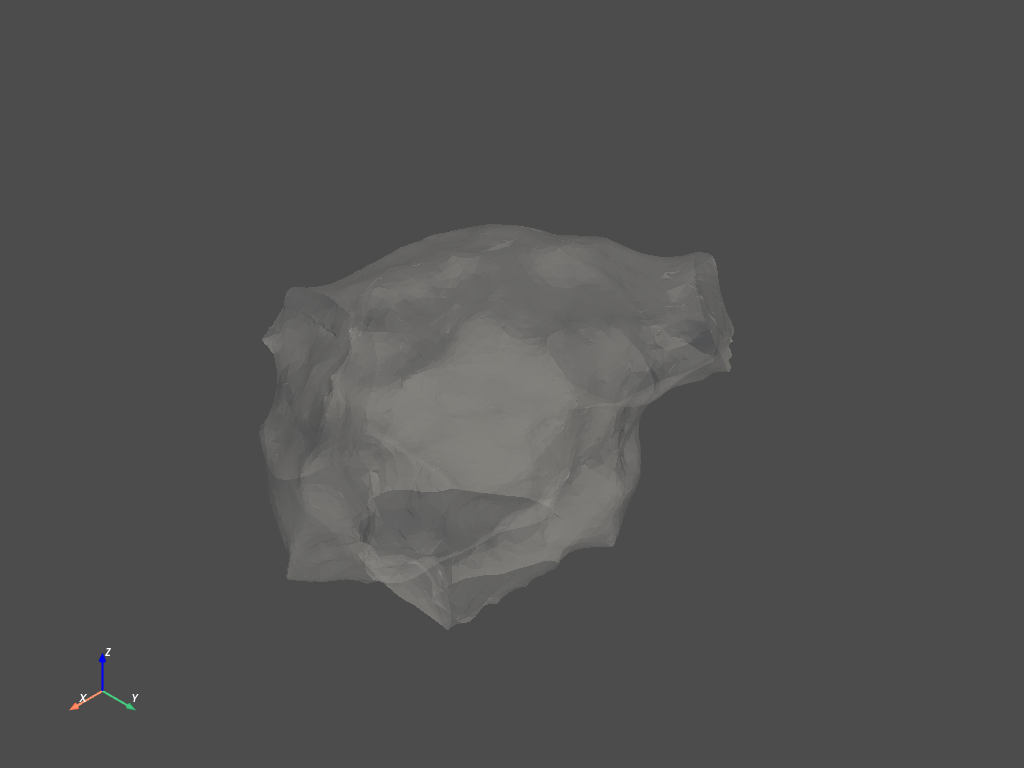

In [77]:
combined_watertight.plot(opacity=0.1)

In [62]:
slices[10].plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [44]:
watertight.plot(opacity=0.2).

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [61]:
slices = voxels.slice_along_axis(axis='x', contour=False, n=200)
slices = combined_watertight.slice_along_axis(axis='x', n=200)

In [68]:
pyvista.voxelize

<function pyvista.utilities.features.voxelize(mesh, density=None, check_surface=True)>

In [32]:
plotter = pyvista.Plotter()
plotter.show

<bound method Plotter.show of <pyvista.plotting.plotting.Plotter object at 0x7fb3206d7250>>

In [37]:
slices[100].plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [79]:
slices[2].plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [57]:
slices[10].plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [9]:
for s in slices:
    try:
        s.plot()
    except:
        pass

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [10]:
combined.plot(scalars='Colour')


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [ ]:
slices.plot()

In [12]:
combined.save('mesh.vtk')